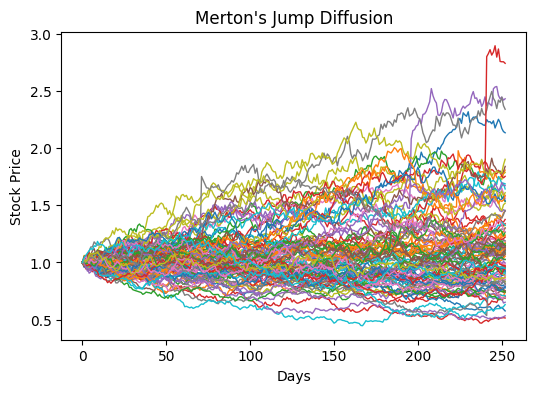

In [19]:
from datetime import date, timedelta, datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def MertonJD(S0 = 1, T = 1, mu = 0.12, sigma = 0.3, lamb = 0.25, a = 0.1, b = 0.2, nSteps = 252, nPaths = 100):
    T_vec, dt = np.linspace(0, T, nSteps+1, retstep = True)
    S_arr = np.zeros([nPaths, nSteps+1])
    S_arr[:,0] = S0
    Z_1 = np.random.normal(size = (nPaths, nSteps))
    Z_2 = np.random.normal(size = (nPaths, nSteps))
    Pois = np.random.poisson(lamb*dt, (nPaths, nSteps))
    for i in range(nSteps):
        S_arr[:,i+1] = S_arr[:,i]*np.exp((mu - sigma**2/2)*dt + sigma*np.sqrt(dt) * Z_1[:,i] + a*Pois[:,i] + b * np.sqrt(Pois[:,i]) * Z_2[:,i])
    plt.figure(figsize = (6,4))
    ax = plt.axes()
    ax.plot(T_vec*nSteps, S_arr.T, linewidth = 1)
    ax.set(title = "Merton's Jump Diffusion", xlabel = 'Days', ylabel = 'Stock Price')
    #plt.savefig('figs/jd_paths.png', dpi = 1000)
    plt.show()
MertonJD()

In [31]:
def MertonJD(S0 = 1,  r = 0.12, sigma = 0.3, T = 1, lamb = 0.25, a = 0.1, b = 0.2, nSteps = 252, nPaths = 1000):
    T_vec, dt = np.linspace(0, T, nSteps+1, retstep = True)
    S_arr = np.zeros([nPaths, nSteps+1])
    S_arr[:,0] = S0
    Z_1 = np.random.normal(size = (nPaths, nSteps))
    Z_2 = np.random.normal(size = (nPaths, nSteps))
    Pois = np.random.poisson(lamb*dt, (nPaths, nSteps))
    for i in range(nSteps):
        S_arr[:,i+1] = S_arr[:,i]*np.exp((r - sigma**2/2)*dt + sigma*np.sqrt(dt) * Z_1[:,i] + a*Pois[:,i] + b * np.sqrt(Pois[:,i]) * Z_2[:,i])
    return S_arr


def MJD(S0, K, T, sigma, r, type):
    """
    S0 = stock price at first day
    K = strike
    T = time in years
    sigma = sigma
    r = risk free rate
    type = call/put
    """
    X = MertonJD(S0, r, sigma, T)
    S = np.mean(X[:,-1])
    if type == "puts":
        price = np.exp(-r*T)*max(0,K-S)
    elif type == "calls":
        price = np.exp(-r*T)*max(0,S-K)
    else:
        raise Exception("Unexpected input")
    
    return price

MJD(182,70,8/365,0.07,0.33223, "calls")

112.54468262678549

In [1]:
from datetime import date, timedelta, datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import Price_Models as pm
import Data as data

Update = False # Set to true to update database from online data, update is necessary if following values have been changed
trade_days = 256

#-- Desired interval examined --
start_date = date(2018,11,7)
end_date = date(2023,11,14)
df_end = end_date + timedelta(days=1) #Add one day as yf functions don't include last day

df_stock = data.getstock(start_date, df_end, Update)
df_options = data.getoptions(Update)

df_options.tail()

expiration   strike  lastPrice lastTradeDate  inTheMoney
symbol optionType                                                          
^SPX   puts        2028-12-15   6200.0    1130.00    2023-10-12        True
       puts        2028-12-15   6800.0    1512.00    2023-10-06        True
       puts        2028-12-15   8000.0    2382.10    2023-10-31        True
       puts        2028-12-15   9600.0    3741.43    2023-06-20        True
       puts        2028-12-15  12000.0    5403.00    2023-10-24        True

In [2]:
sigma = []
r = []

for i in df_stock.columns:
    # Compute average yearly return
    ret = df_stock[i].pct_change().dropna()
    avg_daily_r = np.average(ret)
    avg_annual_r = (1+avg_daily_r)**trade_days - 1

    # Compute yearly volatility of stock from log returns
    log_ret = np.log(df_stock[i]) - np.log(df_stock[i].shift(1))
    daily_std = np.std(log_ret)
    annual_std = daily_std * np.sqrt(trade_days)

    # Append for each stock
    r.append(avg_annual_r)
    sigma.append(annual_std)

stock_values = pd.DataFrame(columns=df_stock.columns, index=['r','sigma'])
stock_values.loc['r'] = r
stock_values.loc['sigma'] = sigma
stock_values


,^SPX,AAPL,AMZN,NFLX,GOOG
r,0.12635,0.38022,0.184465,0.196165,0.266418
sigma,0.219148,0.331937,0.364364,0.485484,0.323247


In [3]:
# Add maturity column to database
df_options['maturity'] = (pd.to_datetime(df_options['expiration']) - pd.to_datetime(df_options['lastTradeDate'])).dt.days
#df_options.loc[['GOOG']].head(20)

# Add S0 columns to database
# Create long version of stock database
df_stock_long = df_stock.reset_index()
df_stock_long = pd.melt(df_stock_long,id_vars='Date',var_name ='stock_name', value_name ='S0')

# Create Volatility column for dataframe
stock_names = df_stock_long['stock_name'].unique()
volatility = []

for i in stock_names:
    stock_series = df_stock_long[df_stock_long['stock_name'] == i]['S0']
    log_ret = np.log(stock_series) - np.log(stock_series.shift(1))
    daily_std = log_ret.expanding().std()
    annual_std = daily_std.array * np.sqrt(trade_days)
    volatility.extend(annual_std)

df_stock_long['sigma'] = volatility
#sigma = df_stock_long[df_stock_long['stock_name'] == 'AAPL']['S0'].expanding().std()
print(df_stock_long.head())

         Date stock_name           S0     sigma
0  2018-11-07       ^SPX  2813.889893       NaN
1  2018-11-08       ^SPX  2806.830078       NaN
2  2018-11-09       ^SPX  2781.010010  0.076136
3  2018-11-12       ^SPX  2726.219971  0.140266
4  2018-11-13       ^SPX  2722.179932  0.135568


In [4]:

df_merged = pd.merge(df_options.reset_index(), df_stock_long, left_on =['symbol','lastTradeDate'], right_on=['stock_name','Date'])
df_merged = df_merged.drop(columns=['Date','stock_name'])
df_merged

,symbol,optionType,expiration,strike,lastPrice,lastTradeDate,inTheMoney,maturity,S0,sigma
0,AAPL,calls,2023-11-17,50.0,137.55,2023-11-14,True,3,187.440002,0.332069
1,AAPL,calls,2023-11-17,60.0,127.55,2023-11-14,True,3,187.440002,0.332069
2,AAPL,calls,2023-11-17,75.0,112.40,2023-11-14,True,3,187.440002,0.332069
3,AAPL,calls,2023-11-17,100.0,87.66,2023-11-14,True,3,187.440002,0.332069
4,AAPL,calls,2023-11-17,110.0,77.10,2023-11-14,True,3,187.440002,0.332069
...,...,...,...,...,...,...,...,...,...,...
21459,^SPX,puts,2027-12-17,6400.0,1657.47,2022-11-30,True,1843,4080.110107,0.233724
21460,^SPX,puts,2027-12-17,7200.0,2238.97,2022-11-30,True,1843,4080.110107,0.233724
21461,^SPX,calls,2027-12-17,3200.0,1263.84,2023-03-13,True,1740,3855.760010,0.230280
21462,^SPX,puts,2027-12-17,1400.0,21.30,2023-07-05,False,1626,4446.819824,0.224982


In [10]:
import LSMC

stock = '^SPX'
r = 0.07



sim_price = []

df = df_merged[df_merged['symbol'] == stock]

est_price = [] 
# iterates through every option in option chain given a certain stock 
for i in range(len(df)):
    S0 = df.iloc[i].S0       # Sets S0
    K = df.iloc[i].strike
    T = df.iloc[i].maturity / 365
    sigma = df.iloc[i].sigma
    method = df.iloc[i].optionType
    computed_price = LSMC.LSMC(S0, K, T, sigma, r, method)
    est_price.append(computed_price)
    
df = df.assign(est_price = est_price)
df

#S0, K, T, sigma, r, method

,symbol,optionType,expiration,strike,lastPrice,lastTradeDate,inTheMoney,maturity,S0,sigma,est_price
8726,^SPX,calls,2023-11-15,1800.0,2392.83,2023-10-31,True,15,4193.799805,0.219563,2511.718798
8727,^SPX,calls,2023-11-15,4105.0,96.26,2023-10-31,True,15,4193.799805,0.219563,160.160994
8728,^SPX,puts,2023-11-15,2400.0,0.05,2023-10-31,False,15,4193.799805,0.219563,0.000000
8729,^SPX,calls,2023-11-16,4120.0,110.32,2023-10-31,True,16,4193.799805,0.219563,181.423107
8730,^SPX,calls,2023-11-16,5400.0,0.05,2023-10-31,False,16,4193.799805,0.219563,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
21459,^SPX,puts,2027-12-17,6400.0,1657.47,2022-11-30,True,1843,4080.110107,0.233724,2307.367085
21460,^SPX,puts,2027-12-17,7200.0,2238.97,2022-11-30,True,1843,4080.110107,0.233724,3441.032951
21461,^SPX,calls,2027-12-17,3200.0,1263.84,2023-03-13,True,1740,3855.760010,0.230280,1333.196325
21462,^SPX,puts,2027-12-17,1400.0,21.30,2023-07-05,False,1626,4446.819824,0.224982,0.000000
